### Parametric Estimation of Bin-based Density Forecast in Surveys 

- Following [Manski et al.(2009)](https://www.tandfonline.com/doi/abs/10.1198/jbes.2009.0003)
- Three cases 
   
   - case 1. 3+ intervals with positive probabilities, or 2 intervals with positive probabilities but open-ended from either end, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent and close-ended bins positive probabilities, to be fitted with a triangle distribution 
   - case 3. __one or multiple__ adjacent intervals with equal probabilities, to be fitted with a uniform distribution
   - cases excluded for now:
     - nonadjacent bins with positive probabilities with bins with zero probs in between 
     -  only one bin with positive probabilities at either end 
   

In [1]:
from scipy.stats import beta
from scipy.stats import triang # new
from scipy.stats import uniform # new
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# We need that for the 90-10 ratio:
def quantile(x,quantiles):
    xsorted = sorted(x)
    qvalues = [xsorted[int(q * len(xsorted))] for q in quantiles]
    return qvalues

### Case 1. Generalized Beta Distribution

In [10]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    parameters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<2:
        print("Warning: at least two bins with positive probs are needed")
        para_est=[]

    else:
        ## cdf used for estimation later 
        cdf = np.cumsum(probs)
        
        ## location and number of positive prob bins for checking patterns 
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        
        ## initial guess and objective function 
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with positive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        
        ## decide how many parameters
        if lb==bin[0] or ub==bin[-1]:
            print('4-parameter beta')
            result = minimize(distance4para,
                              x0_4para,
                              method='CG')
            if result['success']:
                para_est = result['x']
            else:
                ## try one more time with alternative algorithms 
                result = minimize(distance4para,
                              x0_4para,
                              method='BFGS')
                if result['success']:
                    para_est = result['x']
                else:
                    para_est = []

        else:
            print('2-parameter beta')
            result = minimize(distance2para,
                              x0_2para,
                                method='CG')
            if result['success']:
                para_est = result['x']
                para_est = np.concatenate([para_est,
                                          np.array([lb,ub])])
            else:
                ## try one more time with alternative algorithms 
                result = minimize(distance2para,
                              x0_2para,
                                method='BFGS')
                if result['success']:
                    para_est = result['x']
                    para_est = np.concatenate([para_est,
                                          np.array([lb,ub])])
                else:
                    para_est = []
        return para_est   # could be 2 or 4 parameters 

In [11]:
def GeneralizedBetaStats(a,b,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    a, b, lb, ub: floats #changed to a,b instead of alpha and beta
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float
           standard deviation, float
           ratio 90 10, float
    """
    # lb=0 and ub=1 for a standard beta distribution
    #mean = lb + (ub-lb)*a/(a+b)
    #var = (ub-lb)**2*a*b/((a+b)**2*(a+b+1))
    mean, var, skew, kurt = beta.stats(a, 
                                       b, 
                                       loc=lb, 
                                       scale=ub-lb, 
                                       moments='mvsk')
    std = np.sqrt(var)
    # ratio
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    quantiles = quantile(x,[0.1, 0.9])
    iqr1090 = quantiles[1]-quantiles[0]
    return {"mean": mean,
            "variance":var, 
            "std": std, 
            "iqr1090": iqr1090,
            "skewness":skew,
            "kurtosis":kurt}

lower bound is 2.0
upper bound is 3.5
2-parameter beta
[1.28386678 1.72256612 2.         3.5       ]
{'mean': array(2.64055984), 'variance': array(0.13740973), 'std': 0.37068818012062416, 'iqr1090': 0.748726168168818, 'skewness': array(0.2358846), 'kurtosis': array(-0.92936217)}


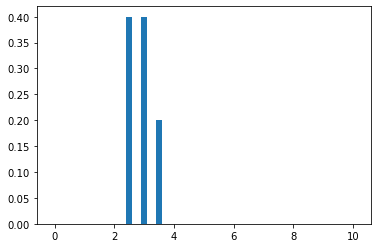

In [13]:
if __name__ == "__main__":
    
    ## test 1: GenBeta Dist
    sim_bins = np.array([-10,0,0.5,1,1.5,2,2.5,3,3.5,4,10])
    sim_probs = np.array([0, 0, 0,  0,  0,  0.4, 0.4, 0.2, 0,  0, ])
    #sim_bins= np.array([-2,0.3,0.6,0.9,1.2,2])
    #sim_probs= np.array([0.0,0.1,0.5,0.4,0.0])
    ## plot
    plt.bar(sim_bins[1:],sim_probs,width=0.2)
    ## estimate
    para_est = GeneralizedBetaEst(sim_bins,sim_probs)
    print(para_est)
    if len(para_est) != 0:
        print(GeneralizedBetaStats(para_est[0],
                            para_est[1],
                            para_est[2],
                             para_est[3]))
    else:
        print('no estimation')

### Case 2. Isosceles Triangle distribution

Two adjacent intervals $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the triangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$

Rearrange to solve for c:
$$ \implies c = (t - b) - \frac{2}{h} $$
$$ \implies c = ub - \frac{2}{h} $$

In [14]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probability to a triangular distribution.
    It generates the bounds of the isosceles triangle distribution.
    
    parameters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
          c: float, mode
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
                c = ub - 2/h
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
                c = ub - 2/h
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
                c = ub - 2/h
        else:
            lb = np.nan
            ub = np.nan
            h = np.nan
            c = np.nan
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h,"mode":c}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [15]:
def TriangleStats(lb,ub,c):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    c : float, mode
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
           std, float 
           irq1090, float  
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    std = np.sqrt(var)
    skew = 0
    kurt = -3/5
    x = np.linspace(triang.ppf(0.01, c, lb, ub), triang.ppf(0.99, c, lb, ub), 100)
    quantiles = quantile(x,[0.1, 0.9])
    iqr1090 = quantiles[1]-quantiles[0]
    return {"mean": mean,
            "variance":var, 
            "std": std, 
            "iqr1090": iqr1090,
           'skewness':skew,
            'kurtosis':kurt}

There are two bins with positive probs
The two intervals are adjacent and not open-ended
{'lb': 0.010263340389897235, 'ub': 0.5, 'height': 4.083827421848046, 'mode': 0.010263340389897235}


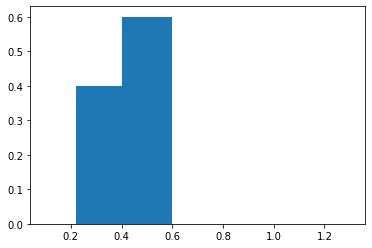

In [16]:
if __name__ == "__main__":
    ## test 2: Triangle Dist
    
    sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
    sim_probs2=np.array([0.0,0.4,0.6,0.0,0])
    ## plot
    plt.bar(sim_bins2[1:],sim_probs2,width=0.2)
    ## estimation 
    para_est = TriangleEst(sim_bins2,sim_probs2)
    print(para_est)
    TriangleStats(para_est['lb'],
                  para_est['ub'], 
                  para_est['mode'])

### Case 3. Uniform Distribution

In [17]:
def UniformEst(bins,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    parameters
    ---------
    bins:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """    
    # find non zero positions
    pos_entry = np.argwhere(probs!=0)
    pos_bins = [bins[i] for i in pos_entry]
    pos_bins = np.hstack(pos_bins)   # clean    

    ## no pos_bins if non-adjacent bins have empty ones in between
    if len(pos_entry)>1:
        for i in range(len(pos_entry)-1) :
            if pos_entry[i+1] - pos_entry[i] !=1:
                pos_bins = [] 
               
    if len(pos_bins)==1:
        print('length pos bins is 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + 1]
        ub = ub[0] # into float
    elif len(pos_bins)>1:
        print('length of pos bins is > 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + len(pos_bins)] 
        ub = ub[0] # into float
    elif len(pos_bins)==0:
        lb=np.nan
        ub=np.nan

    return {"lb":lb,"ub":ub}

In [18]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
           std, float 
           irq1090, float  
    """
    
    if lb is not np.nan and ub is not np.nan: 
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
        std = np.sqrt(var)
        x = np.linspace(uniform.ppf(lb),uniform.ppf(ub), 100)
        p10 = np.percentile(x, 10)
        p90 = np.percentile(x, 90)
        iqr1090 = p90-p10
        skew = 0
        kurt = -5/6
    else:
        mean=np.nan
        var=np.nan
        std = np.nan
        iqr1090 = np.nan
        skew = np.nan
        kurt = np.nan
    return {"mean": mean,
            "variance":var, 
            "std": std, 
            "iqr1090": iqr1090,
            "skewness":skew,
            "kurtosis":kurt}

length pos bins is 1
{'lb': 0.32, 'ub': 0.5}


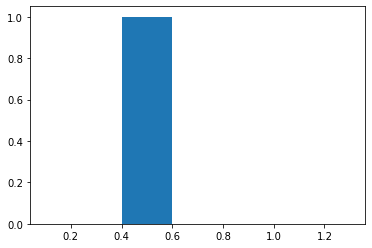

In [19]:
if __name__ == "__main__":
    ## test 3: Uniform Dist with one interval
    sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
    sim_probs3 = np.array([0,0,1,0,0])
    ## plot
    plt.bar(sim_bins3[1:],sim_probs3,width=0.2)
    # Estimation
    para_est= UniformEst(sim_bins3,sim_probs3)
    print(para_est)
    UniformStats(para_est['lb'],para_est['ub']) 

length of pos bins is > 1
{'lb': 0.0, 'ub': 1.2}


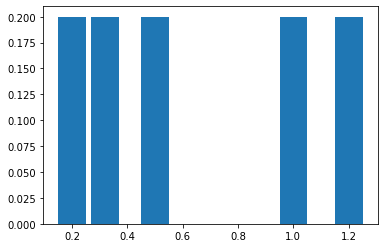

In [20]:
if __name__ == "__main__":
    ## test 4: Uniform Dist with multiple adjacent bins with same probabilities 
    sim_bins4 = np.array([0,0.2,0.32,0.5,1,1.2])
    sim_probs4 = np.array([1/5,1/5,1/5,1/5,1/5])
    ## plot
    plt.bar(sim_bins4[1:],sim_probs4,width=0.1)
    # Estimation
    para_est= UniformEst(sim_bins4,
                         sim_probs4)
    print(para_est)
    UniformStats(para_est['lb'],
                 para_est['ub']) 

{'lb': nan, 'ub': nan}


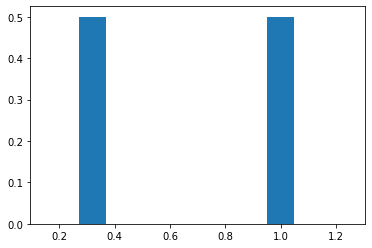

In [21]:
if __name__ == "__main__":
    ## test 5: Uniform Dist with multiple non-adjacent bins with equal probabilities
    sim_bins5 = np.array([0,0.2,0.32,0.5,1,1.2])
    sim_probs5= np.array([0,0.5,0,0.5,0])
    ## plot
    plt.bar(sim_bins5[1:],sim_probs5,width=0.1)
    # Estimation
    para_est = UniformEst(sim_bins5,
                         sim_probs5)
    print(para_est)
    UniformStats(para_est['lb'],
                 para_est['ub']) 

In [22]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    parameters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
            std: empty or float, estimated standard deviation 
            irq1090: empty or float, estimated irq1090 
    
    """
    ## in case there are data entry problems where probs have nan values in certain entries 
    ## for those, replace nan with zero if at least there are positive probs somewhere else.
    if np.any(probs>0.0):
        ## replace it with zeros 
        probs[np.isnan(probs)] = 0.0  
    ## then check if all probs sum up to 1 
    if abs(sum(probs)-1)<1e-4:
        print("probs sum up to 1")
        ## Check if all bins have the same probability (special case for which we need Uniform and not Beta distributions)
        
        # find non zero positions
        pos_entry = np.argwhere(probs>0)
        pos_probs = probs[probs>0]
        pos_bin = [bin[i] for i in pos_entry]
        pos_bin = np.hstack(pos_bin)   # clean    
        
        # special case: if all bins are equally probable
        all_equal = np.all(pos_probs ==1/len(pos_probs))
        print('If all prisitive bins are equally probable? ',str(all_equal))
        
        # special case2: if all bins are equally probable
        open_end = np.min(pos_entry)==0 or np.max(pos_entry)==len(probs)-1
        print('Is there open-ended bins on either side? ', str(open_end))

        if len(pos_entry)>1:
            for i in range(len(pos_entry)-1) :
                if pos_entry[i+1] - pos_entry[i] !=1:
                    pos_bin = [] 
                
                
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3 and all_equal == 0:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
        elif sum([probs[i]>0 for i in range(len(bin)-1)])==2 and open_end:
            ## a special case using beta with only two bins but open-ended  
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
        ## Triangle distributions
        elif sum([probs[i]>0 for i in range(len(bin)-1)])==2 and not all_equal and not open_end:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'], para_est['mode'])
        ## Uniform distributions
        elif sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        elif all_equal == 1:
            print("all bins have the same prob")
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])            
        else:
            print('Does not fall into any given patterns')
            return {"mean":np.nan,
                    'std': np.nan,
                    'iqr1090':np.nan,
                     "variance":np.nan,
                    "skewness":np.nan,
                    "kurtosis":np.nan}
    else:
        print('probs do not sum to 1')
        return {"mean":np.nan,
                'std': np.nan,
                'iqr1090':np.nan,
                "variance":np.nan,
                "skewness":np.nan,
                "kurtosis":np.nan}

probs sum up to 1
If all prisitive bins are equally probable?  False
Is there open-ended bins on either side?  False
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2-parameter beta
{'mean': array(2.64055984), 'variance': array(0.13740973), 'std': 0.37068818012062416, 'iqr1090': 0.748726168168818, 'skewness': array(0.2358846), 'kurtosis': array(-0.92936217)}


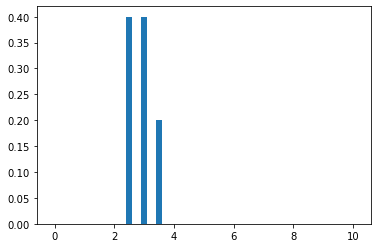

In [23]:
if __name__ == "__main__":
    
    ## test 1 
    ## plot
    plt.bar(sim_bins[1:],sim_probs,width=0.2)
    ## estimate
    para_est = SynDensityStat(sim_bins,sim_probs)
    print(para_est)

probs sum up to 1
If all prisitive bins are equally probable?  False
Is there open-ended bins on either side?  False
There are two bins with positive probs
The two intervals are adjacent and not open-ended
{'mean': 0.25513167019494865, 'variance': 0.009993416490252567, 'std': 0.09996707703165361, 'iqr1090': 0.3597509801816764, 'skewness': 0, 'kurtosis': -0.6}


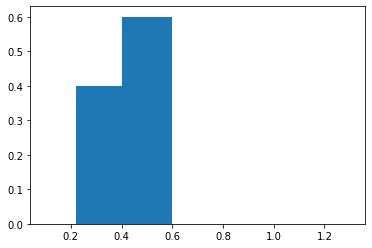

In [35]:
if __name__ == "__main__":
    ## test 2
    ## plot
    plt.bar(sim_bins2[1:],sim_probs2,width=0.2)
    ## estimate
    para_est = SynDensityStat(sim_bins2,sim_probs2)
    print(para_est)

probs sum up to 1
If all prisitive bins are equally probable?  True
Is there open-ended bins on either side?  False
Only one interval with positive probs
length pos bins is 1
{'lb': 0.32, 'ub': 0.5}
{'mean': 0.41000000000000003, 'variance': 0.0026999999999999997, 'std': 0.05196152422706632, 'iqr1090': 0.14399999999999996, 'skewness': 0, 'kurtosis': -0.8333333333333334}


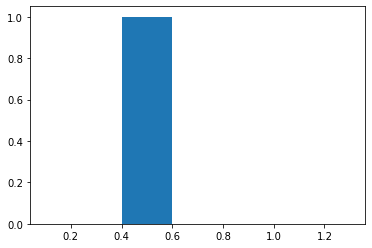

In [36]:
if __name__ == "__main__":
    ## test 3
    ## plot
    plt.bar(sim_bins3[1:],sim_probs3,width=0.2)
    ## estimate
    para_est = SynDensityStat(sim_bins3,sim_probs3)
    print(para_est)

probs sum up to 1
If all prisitive bins are equally probable?  True
Is there open-ended bins on either side?  True
all bins have the same prob
length of pos bins is > 1
{'lb': 0.0, 'ub': 1.2}
{'mean': 0.6, 'variance': 0.12, 'std': 0.34641016151377546, 'iqr1090': nan, 'skewness': 0, 'kurtosis': -0.8333333333333334}


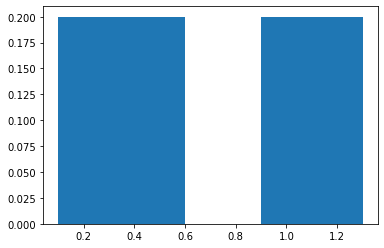

In [37]:
if __name__ == "__main__":
    ## test 4
    ## plot
    plt.bar(sim_bins4[1:],sim_probs4,width=0.2)
    ## estimate
    para_est = SynDensityStat(sim_bins4,sim_probs4)
    print(para_est)

probs sum up to 1
If all prisitive bins are equally probable?  True
Is there open-ended bins on either side?  False
all bins have the same prob
{'lb': nan, 'ub': nan}
{'mean': nan, 'variance': nan, 'std': nan, 'iqr1090': nan, 'skewness': nan, 'kurtosis': nan}


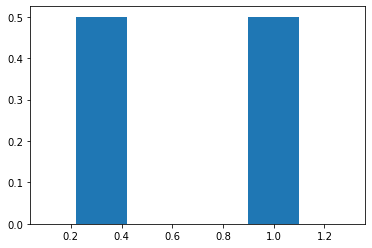

In [38]:
if __name__ == "__main__":
    ## test 5
    ## plot
    plt.bar(sim_bins5[1:],sim_probs5,width=0.2)
    ## estimate
    para_est = SynDensityStat(sim_bins5,sim_probs5)
    print(para_est)